In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

In [2]:
# no. of stimuli x2 for not-stimuli as well
nf = 2*2
stim = {
    0:"X",
    1:"Y",
    2:"NotX",
    3:"NotY"
}
# variables
dt = 0.1
A = np.arange(0,1,0.2)
a = 0.8

In [3]:
#generate a range of s and tau_star
def s_gen(tau_min=1, tau_max=100., buff_max=None, k=20, ntau=40, g=0.0):
    c = (tau_max/tau_min)**(1./(ntau-1))-1
    tau_star = tau_min*(1+c)**np.arange(ntau).astype(float)
    s = 1/tau_star
    return [tau_star, s]
[tau_star, S] = s_gen()

In [4]:
S

array([1.        , 0.88862382, 0.78965229, 0.70170383, 0.62355073,
       0.55410203, 0.49238826, 0.43754794, 0.38881552, 0.34551073,
       0.30702906, 0.27283334, 0.2424462 , 0.21544347, 0.1914482 ,
       0.17012543, 0.15117751, 0.13433993, 0.11937766, 0.10608184,
       0.09426685, 0.08376776, 0.07443803, 0.06614741, 0.05878016,
       0.05223345, 0.04641589, 0.04124626, 0.03665241, 0.03257021,
       0.02894266, 0.02571914, 0.02285464, 0.02030918, 0.01804722,
       0.01603719, 0.01425103, 0.0126638 , 0.01125336, 0.01      ])

In [5]:
def stim_gen(i):
    global nf
    stim_vec = np.zeros(nf)
    if i is not None:
        stim_vec[i] = 1
    return stim_vec

In [6]:
def input_update(a,s,s_idx,fi_IN: None):
    global M
    global F
    global P
    #if fi_IN is not None:
        #print("Inputing stim", stim[fi_IN])
    f_IN = stim_gen(fi_IN)
    #eq 1
    F[s_idx] += -s*F[s_idx] + f_IN
    F[s_idx] = np.where(F[s_idx]<0, 0, F[s_idx])
    #eq 2
    P_IN = np.dot(M[s_idx], f_IN)
    #eq 3
    P[s_idx] +=  s*P[s_idx] + P_IN - P[0]
    P[s_idx] = np.where(P[s_idx]<0, 0, P[s_idx])
    #find stimulis from the past that are still active & update associations
    if fi_IN is not None:
        for past_stim in np.flatnonzero(F[s_idx]):
            #Avoiding self-prediction updates
            if past_stim != fi_IN:
                #eq4 - make sure we're indexing M correctly
                M[s_idx][fi_IN, past_stim] = a * M[s_idx][fi_IN, past_stim] + (1-a) * F[s_idx][past_stim]
def detect_notstim(a,t,s,s_idx,fi_IN:None):
    global M
    global F
    global P
    predicted = np.where(P[s_idx]>=1)[0]
    #iterate through them
    for p in predicted:
        if p == fi_IN:
            print(stim[p], "Observed & Predicted with p=%s! at at s=%s and t=%s"
                  %(P[s_idx][p],s,t))
            P[s_idx][p] = 0
        else:
            P[s_idx][p] = 0
            if p < 2:
                print(stim[p+2], "predicted at s=%s and t=%s" %(s,t))
                #add 2 to get the not-stimuli equivalent
                input_update(a,s,s_idx,fi_IN=p+2)
            else:
                print(stim[p], "predicted at s=%s and t=%s" %(s,t))
                input_update(a,s,s_idx, fi_IN=p)
def timestep_update(a,t,S,fi_IN: None):
    for s_idx, s in enumerate(S):
        input_update(a,s,s_idx,fi_IN)
        detect_notstim(a,t,s,s_idx,fi_IN) 

In [8]:
#alter this for different stimuli presentation at different times
t_max = 7.1
T = np.arange(0,t_max, dt)
#pick an s value to track
s_track = [1,3,7,19,27]
f = [[0,1],[1,3],[0,7],[0,t_max+0.1]]
P_tracker = np.ndarray(shape=(len(T), len(s_track), nf), dtype=float)
F_tracker = np.ndarray(shape=(len(T), len(s_track), nf), dtype=float)

In [9]:
M = np.zeros([len(S), nf, nf])
F = np.zeros([len(S), nf])
P = np.zeros([len(S), nf])
for t in T:
    if f[0][1] == t:
        fi_IN = f[0][0]
        timestep_update(a,t,S,fi_IN=fi_IN)
        f.pop(0)
    else:
        timestep_update(a,t,S,fi_IN=None)
    t_idx = int(t*10)
    for s_idx, s in enumerate(s_track):
        P_tracker[t_idx,s_idx] = P[s]
        F_tracker[t_idx,s_idx] = F[s]

In [13]:
P_tracker[:,0,1]

71

In [12]:
F_tracker[:,0,1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.11376184e-01,
       1.24046543e-02, 1.38158306e-03, 1.53875448e-04, 1.71380602e-05,
       1.90877174e-06, 2.12591712e-07, 2.36776536e-08, 2.63712670e-09,
       2.93713108e-10, 3.27126450e-11, 3.64340956e-12, 4.05789053e-13,
       4.51952361e-14, 5.03367292e-15, 5.60631280e-16, 6.24409724e-17,
       6.95443722e-18, 7.74558677e-19, 8.62673896e-20, 9.60813263e-21,
       1.07011714e-21, 1.19185564e-22, 1.32744332e-23, 1.47845572e-24,
      

In [14]:
M[1]

array([[0.00000000e+00, 1.48841250e-39, 0.00000000e+00, 0.00000000e+00],
       [1.72534779e-20, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [18]:
np.dot(M[1],stim_gen(fi_IN))

array([0.00000000e+00, 1.72534779e-20, 0.00000000e+00, 0.00000000e+00])

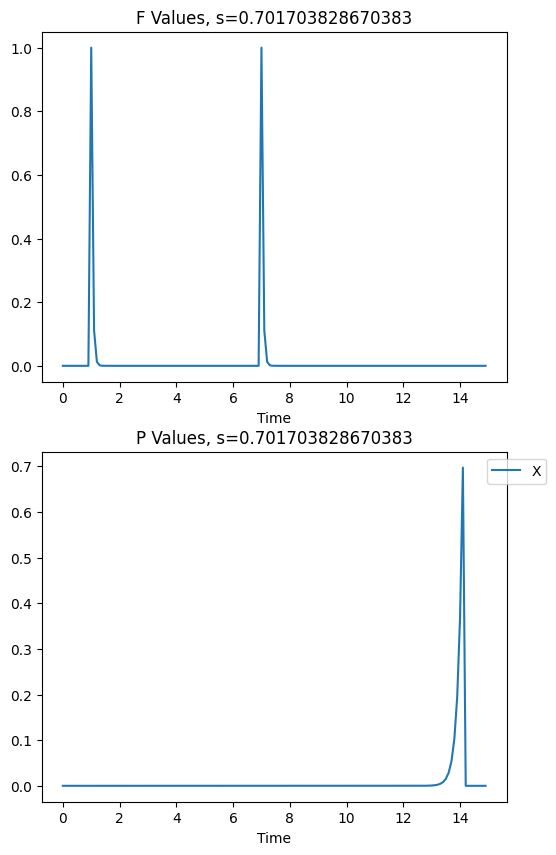

In [32]:
#plot individual s value
fig = plt.figure(figsize = (6,10))
ax = fig.subplots(2,1)
ax[0].plot(T, F_tracker[:,0,0])
ax[0].set_title("F Values, s=%s" %(S[s_track[1]]))
ax[0].set_xlabel("Time")
#ax[0].legend(['X', 'Y','Not X', 'Not Y'])

ax[1].plot(T, P_tracker[:,0,1])
ax[1].set_title("P Values, s=%s" %(S[s_track[1]]))
ax[1].set_xlabel("Time")
ax[1].legend(['X', 'Y','Not-X (X predicted, not observed)', 'Not Y (Y predicted, not observed)']
             ,bbox_to_anchor=(1.1, 1))

Text(11, 3.4, 'Y Predictions')

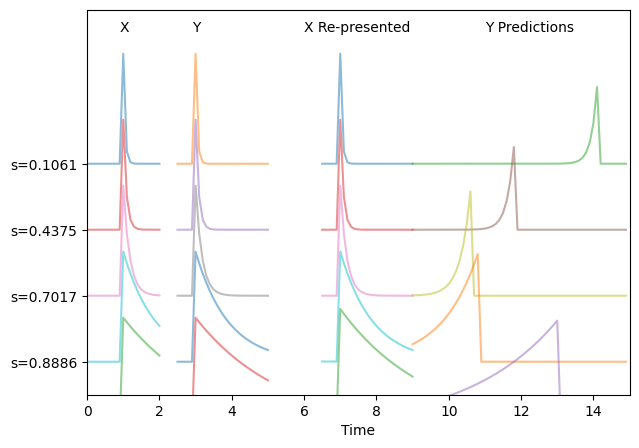

In [33]:
fig2,ax2 = plt.subplots(figsize = (7,5))
for idx in range(len(s_track)):
    #lower index = higher s value = higher position on plot
    plot_inc = 0.6 * (3.5-idx)
    #F_masked = F_tracker[:,idx,0]+plot_inc
    F_X_masked = np.ma.masked_where(((T>2)&(T<6.5))|(T>9.0),(F_tracker[:,idx,0]+plot_inc))
    F_Y_masked = np.ma.masked_where((T<2.5)|(T>5.0),(F_tracker[:,idx,1]+plot_inc))
    P_masked = np.ma.masked_where((T<9.0), (P_tracker[:,idx,1]+plot_inc))
    #P_masked = P_tracker[:,idx,1]+plot_inc
    ax2.plot(T,F_X_masked, alpha=0.5)
    ax2.plot(T,F_Y_masked, alpha=0.5)
    ax2.plot(T,P_masked,alpha=0.5)
ax2.set_ylim(0, 3.5)
ax2.set_xlim(0, 15.0)
ax2.set_xlabel('Time')
ax2.set_yticks([0.3, 0.9, 1.5, 2.1],
               ['s=%s' %(S[s_track[3]].round(4)),
                's=%s' %(S[s_track[2]].round(4)),
                's=%s' %(S[s_track[1]].round(4)),
                's=%s' %(S[s_track[0]].round(4))
               ])
ax2.text(0.9,3.4, "X", verticalalignment='top')
ax2.text(2.9,3.4, "Y", verticalalignment='top')
ax2.text(6,3.4, "X Re-presented", verticalalignment='top')
ax2.text(11,3.4, "Y Predictions", verticalalignment='top')

In [19]:
F_tracker[:,0,:]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.98296171e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.89806058e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.65425740e-02, 0.00000000e+00, 0.00000000e

In [34]:
np.argwhere(P_tracker[:,0,1])

array([[ 70],
       [ 71],
       [ 72],
       [ 73],
       [ 74],
       [ 75],
       [ 76],
       [ 77],
       [ 78],
       [ 79],
       [ 80],
       [ 81],
       [ 82],
       [ 83],
       [ 84],
       [ 85],
       [ 86],
       [ 87],
       [ 88],
       [ 89],
       [ 90],
       [ 91],
       [ 92],
       [ 93],
       [ 94],
       [ 95],
       [ 96],
       [ 97],
       [ 98],
       [ 99],
       [100],
       [101],
       [102],
       [103],
       [104],
       [105],
       [106],
       [107],
       [108],
       [109],
       [110],
       [111],
       [112],
       [113],
       [114],
       [115],
       [116],
       [117],
       [118],
       [119],
       [120],
       [121],
       [122],
       [123],
       [124],
       [125],
       [126],
       [127],
       [128],
       [129],
       [130],
       [131],
       [132],
       [133],
       [134],
       [135],
       [136],
       [137],
       [138],
       [139],
       [140],
      

In [35]:
P_tracker[70:,1,1]

array([6.22276756e-12, 1.05893074e-11, 1.80198649e-11, 3.06644731e-11,
       5.21818513e-11, 8.87980562e-11, 1.51107992e-10, 2.57141049e-10,
       4.37577907e-10, 7.44628000e-10, 1.26713632e-09, 2.15629073e-09,
       3.66936818e-09, 6.24417789e-09, 1.06257414e-08, 1.80818648e-08,
       3.07699786e-08, 5.23613905e-08, 8.91035786e-08, 1.51627901e-07,
       2.58025779e-07, 4.39083457e-07, 7.47190000e-07, 1.27149608e-06,
       2.16370975e-06, 3.68199317e-06, 6.26566187e-06, 1.06623008e-05,
       1.81440781e-05, 3.08758472e-05, 5.25415473e-05, 8.94101523e-05,
       1.52149598e-04, 2.58913554e-04, 4.40594186e-04, 7.49760814e-04,
       1.27587085e-03, 2.17115431e-03, 3.69466160e-03, 6.28721978e-03,
       1.06989860e-02, 1.82065054e-02, 3.09820799e-02, 5.27223241e-02,
       8.97177807e-02, 1.52673091e-01, 2.59804383e-01, 4.42110114e-01,
       7.52340474e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [36]:
P_tracker[70:,0,1]

array([1.72534779e-20, 3.25853293e-20, 6.15414290e-20, 1.16228608e-19,
       2.19512118e-19, 4.14575814e-19, 7.82977756e-19, 1.47875044e-18,
       2.79280330e-18, 5.27455482e-18, 9.96164985e-18, 1.88138092e-17,
       3.55322080e-17, 6.71069744e-17, 1.26739830e-16, 2.39363861e-16,
       4.52068289e-16, 8.53786938e-16, 1.61248235e-15, 3.04537256e-15,
       5.75156315e-15, 1.08625391e-14, 2.05152501e-14, 3.87455900e-14,
       7.31758440e-14, 1.38201642e-13, 2.61010912e-13, 4.92951425e-13,
       9.30999801e-13, 1.75830840e-12, 3.32078312e-12, 6.27171008e-12,
       1.18449010e-11, 2.23705622e-11, 4.22495765e-11, 7.97935565e-11,
       1.50700011e-10, 2.84615630e-10, 5.37531858e-10, 1.01519547e-09,
       1.91732234e-09, 3.62110063e-09, 6.83889690e-09, 1.29161036e-08,
       2.43936608e-08, 4.60704487e-08, 8.70097467e-08, 1.64328680e-07,
       3.10355059e-07, 5.86143955e-07, 1.10700543e-06, 2.09071683e-06,
       3.94857759e-06, 7.45737768e-06, 1.40841811e-05, 2.65997198e-05,
      

In [ ]:
#plot using imshow
#fig = plt.figure(figsize = (5,10))
#ax = fig.subplots(2,1)
#ax[0].imshow(F_tracker, aspect='auto')
#ax[0].set_title("F Values, s=%s" %(S[s_track]))
#ax[0].set_ylabel("Time")
#ax[0].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])
#ax[1].imshow(P_tracker, aspect='auto')
#ax[1].set_title("P Values, s=%s" %(S[s_track]))
#ax[1].set_ylabel("Time")
#ax[1].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])
#ax[2].imshow(P_max, aspect='auto')
#ax[2].set_title("P Values, s=%s" %(S[-1]))
#ax[2].set_ylabel("Time")
#ax[2].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])

In [ ]:
#plot tracked variables through time - doesn't work yet
#x = np.arange(nf)
#fig = plt.figure()
#ax = fig.subplots(3,1)
#i = 0
#F_plot = ax[0].scatter(x, F_tracker[i])
#P_plot = ax[2].scatter(x, P_tracker[i])
#M_plot = ax[1].pcolormesh(M_tracker[i])

#def update(i=0.0):
#    idx = int(i*10)
#    F_plot.set_offsets(np.c_[x,F_tracker[idx]])
#    P_plot.set_offsets(np.c_[x,P_tracker[idx]])
#    M_plot.set_array(M_tracker[idx])
#    #scatter.set_ydata(Tracker[idx])
#    fig.canvas.draw_idle()

#interact(update, i = (0.0,t_max,dt));